### Libraries & Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime
import os

In [2]:
from src.phasenet.train import train
from src.phasenet.visualize import plot_stream_with_predictions, plot_fetched_waveforms
from src.phasenet.stream import make_stream, predict_stream, fetch_and_annotate_waveforms
from src.phasenet.model import get_phasenet_model, get_device, load_model_from_path
from src.phasenet.data_processing import load_data, split_data, create_generator, create_dataloader, create_augmentations
from src.constants import IQUIQUE_FOLDER_PATH, PHASENET_MODELS_DIR

c:\Users\barte\OneDrive\Pulpit\FO - projekt\FO--ml-seismic-classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparing model

In [3]:
device = get_device()
print("Using device:", device)

Using device: cuda


In [4]:
untrainded_model = get_phasenet_model()
pretrained_model = get_phasenet_model(pretrained_version="geofon")

c:\Users\barte\OneDrive\Pulpit\FO - projekt\FO--ml-seismic-classifier\.venv\Lib\site-packages\seisbench\models\base.py:899: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mod

### Preparing data

In [5]:
dataset = load_data(IQUIQUE_FOLDER_PATH)
train_ds, dev_ds, test_ds = split_data(dataset)

2026-01-11 22:35:02,373 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


In [6]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [7]:
untrained_augmentations = create_augmentations(phase_dict, untrainded_model)
prerained_augmentations = create_augmentations(phase_dict, pretrained_model)

In [8]:
train_generator_untrained = create_generator(train_ds, untrained_augmentations)
train_generator_pretrained = create_generator(train_ds, prerained_augmentations)

val_generator_untrained = create_generator(dev_ds, untrained_augmentations)
val_generator_pretrained = create_generator(dev_ds, prerained_augmentations)

In [9]:
train_loader_untrained = create_dataloader(train_generator_untrained, batch_size=256, num_workers=4)
train_loader_pretrained = create_dataloader(train_generator_pretrained, batch_size=256, num_workers=4)

val_loader_untrained = create_dataloader(val_generator_untrained, batch_size=256, num_workers=4)
val_loader_pretrained = create_dataloader(val_generator_pretrained, batch_size=256, num_workers=4)

### Preditions before training

In [10]:
random_index = np.random.randint(len(dataset))
print("Random index selected:", random_index)

Random index selected: 5455


In [11]:
stream = make_stream(dataset, random_index)
print(stream)

3 Trace(s) in Stream:
DG.IN02..EHZ | 2014-05-15T11:06:06.450000Z - 2014-05-15T11:08:44.100000Z | 100.0 Hz, 15766 samples
DG.IN02..EHN | 2014-05-15T11:06:06.450000Z - 2014-05-15T11:08:44.100000Z | 100.0 Hz, 15766 samples
DG.IN02..EHE | 2014-05-15T11:06:06.450000Z - 2014-05-15T11:08:44.100000Z | 100.0 Hz, 15766 samples


In [12]:
untrained_annotations = predict_stream(untrainded_model, stream)
pretrained_annotations = predict_stream(pretrained_model, stream)

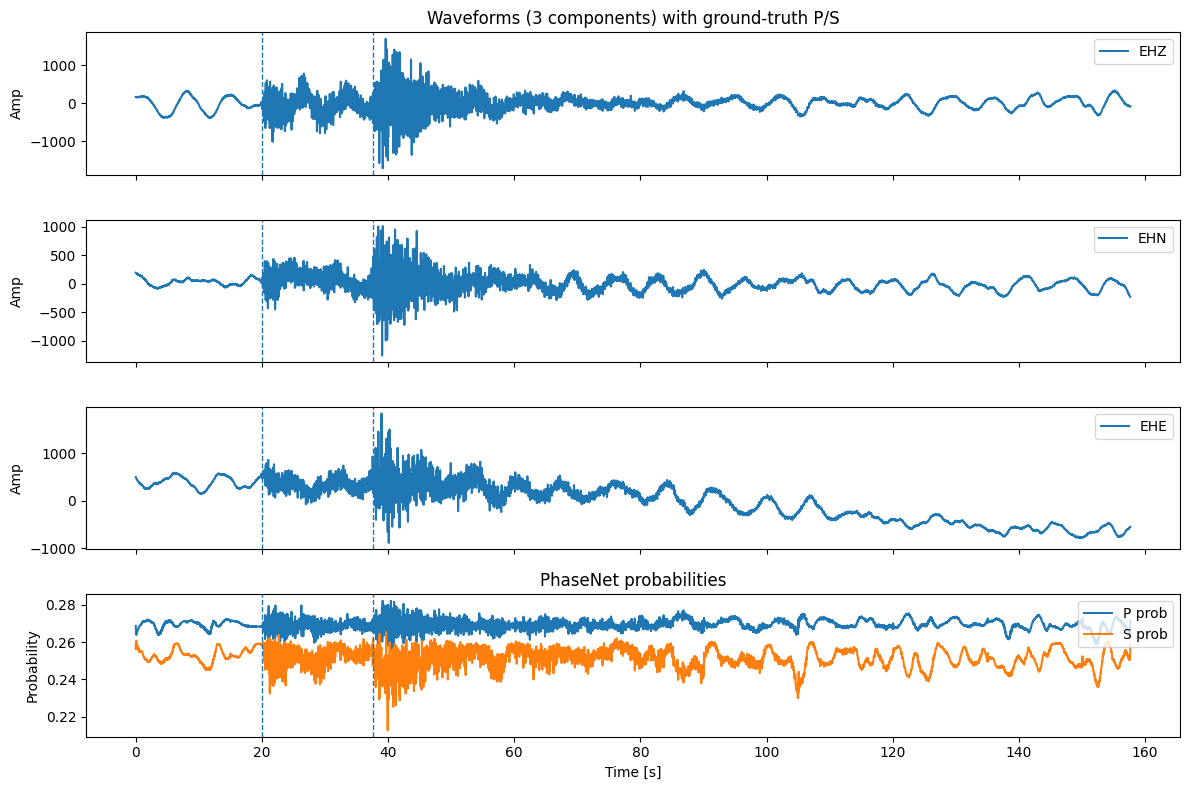

In [13]:
plot_stream_with_predictions(stream, untrained_annotations, metadata=dataset.metadata.iloc[random_index])

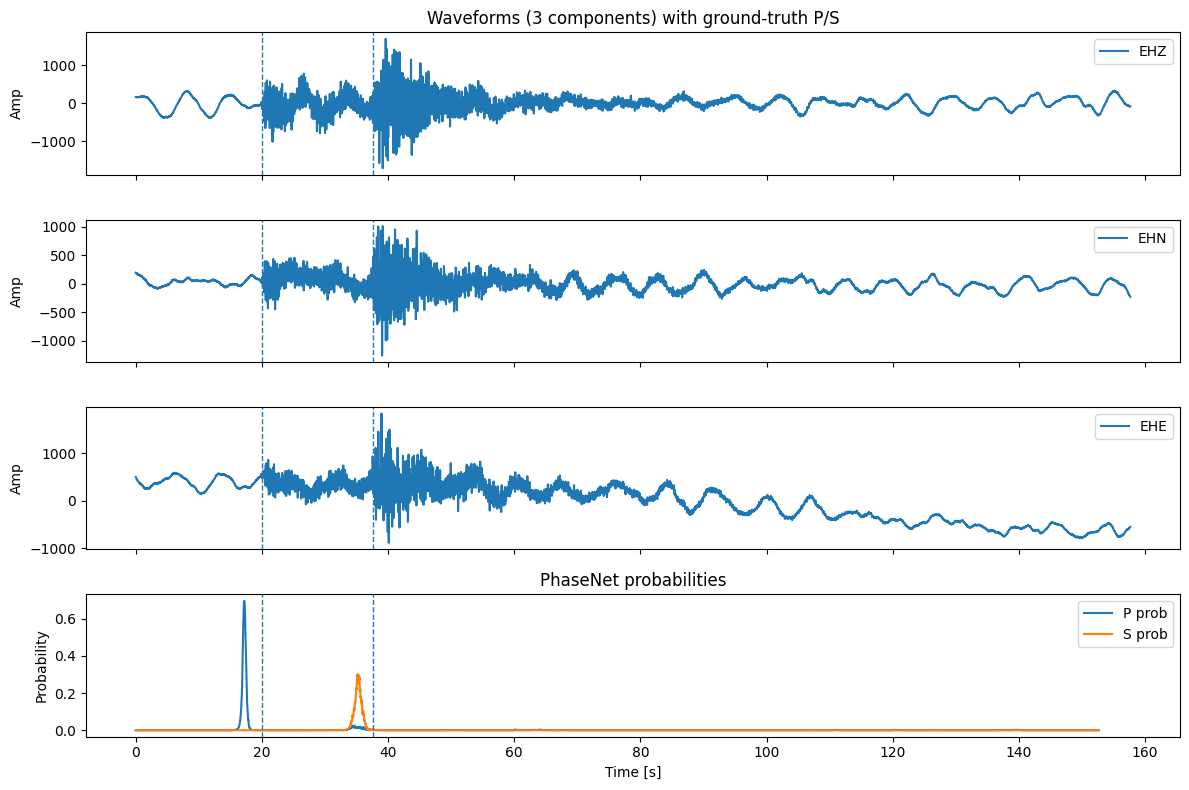

In [14]:
plot_stream_with_predictions(stream, pretrained_annotations, metadata=dataset.metadata.iloc[random_index])

### Training 

In [15]:
EPOCHS = 10
learning_rate = 1e-3
untrained_optimizer = torch.optim.Adam(untrainded_model.parameters(), lr=learning_rate)
pretrained_optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)

#### Training untrained model

In [16]:
untrained_model_save_dir = PHASENET_MODELS_DIR / "not_pretrained"
os.makedirs(untrained_model_save_dir, exist_ok=True)

train(untrainded_model, untrained_optimizer, train_loader_untrained, val_loader_untrained, epochs=EPOCHS, device=device, save_directory=untrained_model_save_dir)

Epoch 1
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Train Loss: 1.135427 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]


Eval Loss: 0.869222 

Model saved!
Epoch 2
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:16<00:00,  1.97it/s]


Train Loss: 0.889822 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


Eval Loss: 0.738273 

Model saved!
Epoch 3
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


Train Loss: 0.727198 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Eval Loss: 0.578688 

Model saved!
Epoch 4
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]


Train Loss: 0.597709 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


Eval Loss: 0.477338 

Model saved!
Epoch 5
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train Loss: 0.492111 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


Eval Loss: 0.407708 

Model saved!
Epoch 6
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]


Train Loss: 0.406929 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


Eval Loss: 0.358090 

Model saved!
Epoch 7
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]


Train Loss: 0.334073 



Evaluating Batches: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Eval Loss: 0.292852 

Model saved!
Epoch 8
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]


Train Loss: 0.274975 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Eval Loss: 0.279364 

Model saved!
Epoch 9
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


Train Loss: 0.230263 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


Eval Loss: 0.247425 

Model saved!
Epoch 10
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Train Loss: 0.195342 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]

Eval Loss: 0.241588 

Model saved!
Training complete!


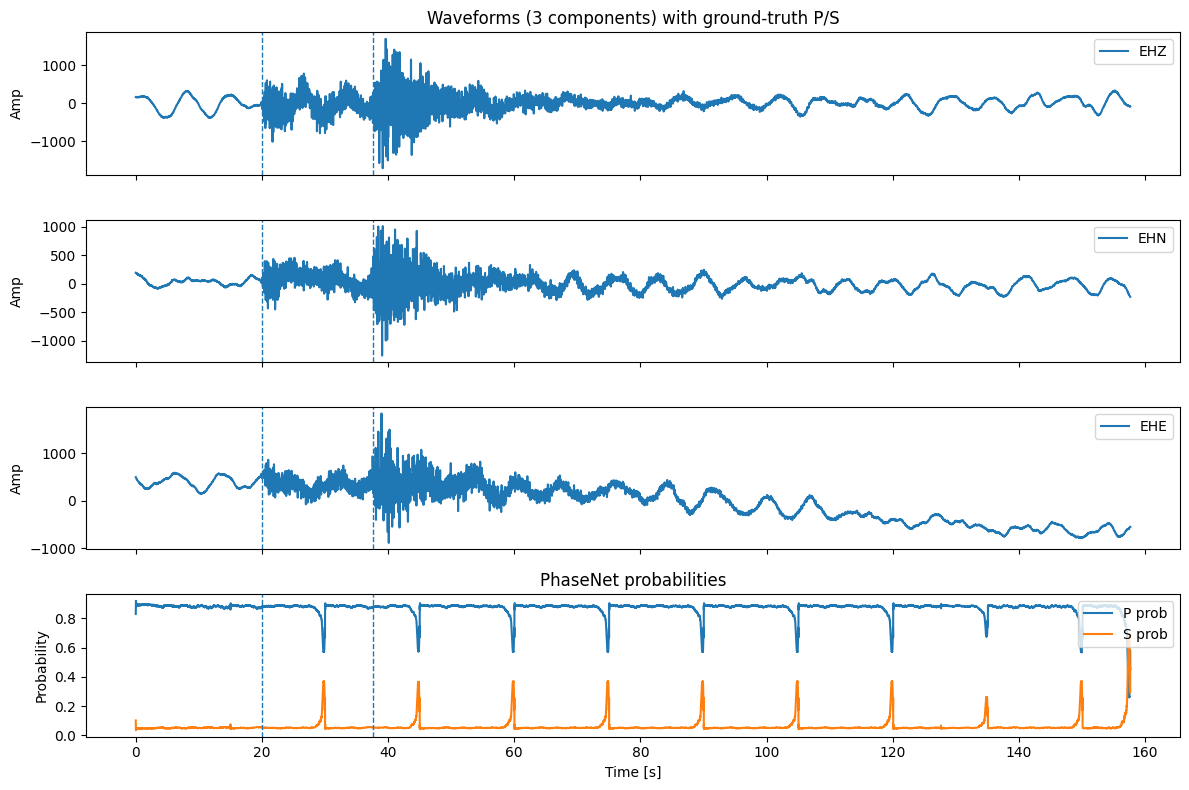

In [17]:
new_untrained_annotations = predict_stream(untrainded_model, stream)
plot_stream_with_predictions(stream, new_untrained_annotations, metadata=dataset.metadata.iloc[random_index])

#### Training pretrained model

In [18]:
pretrained_model_save_dir = PHASENET_MODELS_DIR / "pretrained_geofon"
os.makedirs(pretrained_model_save_dir, exist_ok=True)
train(pretrained_model, pretrained_optimizer, train_loader_pretrained, val_loader_pretrained, epochs=EPOCHS, device=device, save_directory=pretrained_model_save_dir)

Epoch 1
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Train Loss: 0.106472 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.33it/s]


Eval Loss: 0.080133 

Model saved!
Epoch 2
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


Train Loss: 0.073542 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Eval Loss: 0.070905 

Model saved!
Epoch 3
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


Train Loss: 0.067985 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


Eval Loss: 0.068178 

Model saved!
Epoch 4
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]


Train Loss: 0.065050 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


Eval Loss: 0.063543 

Model saved!
Epoch 5
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]


Train Loss: 0.062767 



Evaluating Batches: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]


Eval Loss: 0.063758 

Epoch 6
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Train Loss: 0.061259 



Evaluating Batches: 100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


Eval Loss: 0.062237 

Model saved!
Epoch 7
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Train Loss: 0.060335 



Evaluating Batches: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


Eval Loss: 0.062173 

Model saved!
Epoch 8
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]


Train Loss: 0.058975 



Evaluating Batches: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Eval Loss: 0.059923 

Model saved!
Epoch 9
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s]


Train Loss: 0.058080 



Evaluating Batches: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]


Eval Loss: 0.060691 

Epoch 10
-------------------------------


Training Batches: 100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


Train Loss: 0.057700 



Evaluating Batches: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

Eval Loss: 0.059197 

Model saved!
Training complete!


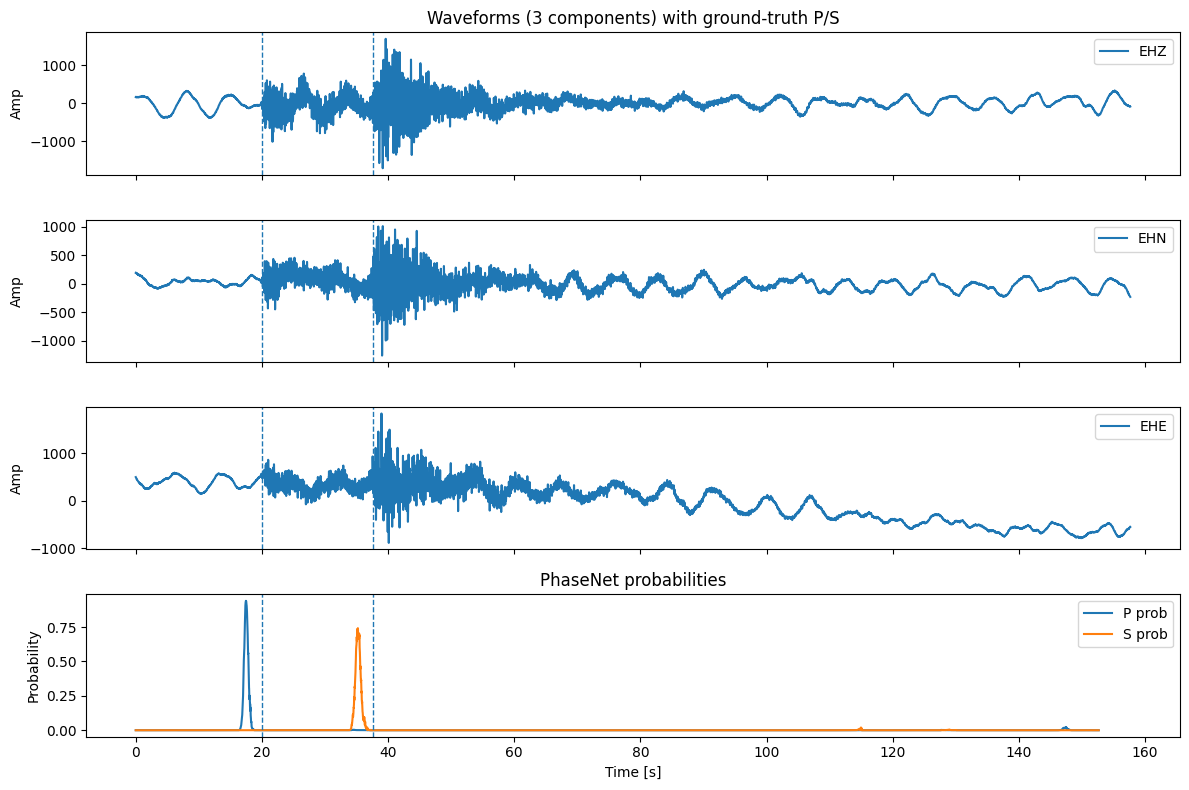

In [19]:
new_pretrained_annotations = predict_stream(pretrained_model, stream)
plot_stream_with_predictions(stream, new_pretrained_annotations, metadata=dataset.metadata.iloc[random_index])

#### Testing models on unseen data

In [24]:
t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream, annotations = fetch_and_annotate_waveforms(
    pretrained_model,
    provider="ETH",
    t=t,
    network="CH",
    station="EMING",
    location="*",
    channel="HH?",
    pre_s=30,
    post_s=50,
)

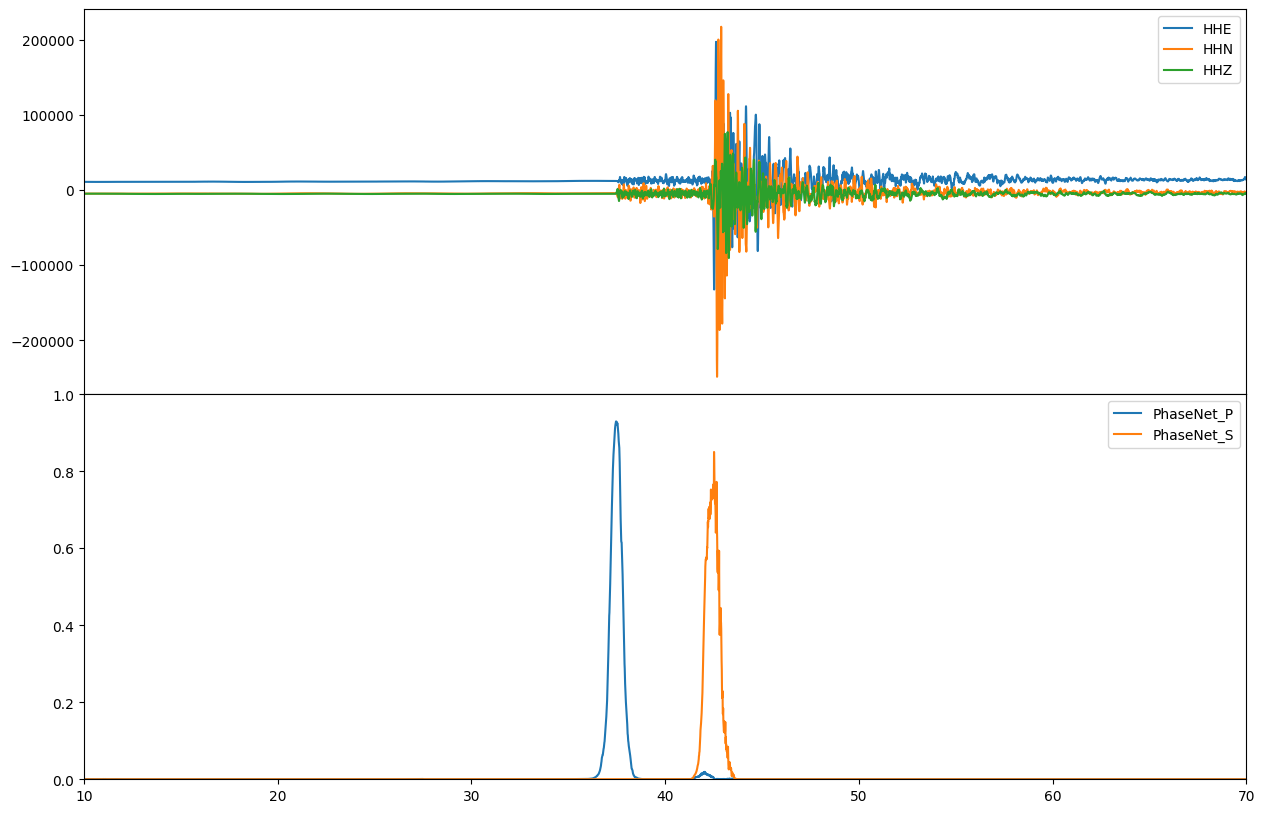

In [25]:
fig = plot_fetched_waveforms(stream, annotations)